In [39]:
# Import libraries
import os
import numpy as np
import pandas as pd 
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import InceptionV3
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping


In [4]:
# Set dataset path
# Dataset from https://www.kaggle.com/datasets/gpiosenka/70-dog-breedsimage-data-set/data

train_dir = '/Users/sandrachee/Documents/DeepLearningProjects/dogs/train'
test_dir = '/Users/sandrachee/Documents/DeepLearningProjects/dogs/test'

In [5]:
# Parameters
img_size = 299
batch_size = 32

num_classes = len(os.listdir(train_dir))  #  each folder in train_dir represents a class
print(num_classes)

70


In [6]:
# Data augmentation and preprocessing
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=30,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest'
)

test_datagen = ImageDataGenerator(rescale=1./255)

train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=(img_size, img_size),
    batch_size=batch_size,
    class_mode='categorical'
)

test_generator = test_datagen.flow_from_directory(
    test_dir,
    target_size=(img_size, img_size),
    batch_size=batch_size,
    class_mode='categorical'
)

Found 7946 images belonging to 70 classes.
Found 700 images belonging to 70 classes.


In [7]:
# Load model
base_model = InceptionV3(weights='imagenet', include_top=False, input_shape=(img_size, img_size, 3))

In [8]:
# Freeze base model layer
base_model.trainable = False

In [9]:
# Add custom layer
x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dense(1024, activation='relu')(x)
predictions = Dense(num_classes, activation='softmax')(x)

In [10]:
# Define the final model
model = Model(inputs=base_model.input, outputs=predictions)

In [11]:
# Compile the model
model.compile(optimizer=Adam(learning_rate=0.0001),
              loss='categorical_crossentropy',
              metrics=['accuracy'])

In [15]:
# Define callbacks (optional but recommended)
checkpoint = ModelCheckpoint('/Users/sandrachee/Documents/best_model.keras', monitor='val_loss', save_best_only=True, mode='min', verbose=1)
early_stopping = EarlyStopping(monitor='val_loss', patience=10, verbose=1, restore_best_weights=True)

In [16]:
# Train the model
epochs = 5

history = model.fit(
    train_generator,
    epochs=epochs,
    validation_data=test_generator,
    callbacks=[checkpoint, early_stopping]
)

Epoch 1/5
249/249 ━━━━━━━━━━━━━━━━━━━━ 0s 3s/step - accuracy: 0.8850 - loss: 0.4198
Epoch 1: val_loss improved from inf to 0.14904, saving model to /Users/sandrachee/Documents/best_model.keras
249/249 ━━━━━━━━━━━━━━━━━━━━ 784s 3s/step - accuracy: 0.8850 - loss: 0.4197 - val_accuracy: 0.9600 - val_loss: 0.1490
Epoch 2/5
249/249 ━━━━━━━━━━━━━━━━━━━━ 0s 3s/step - accuracy: 0.8997 - loss: 0.3383
Epoch 2: val_loss improved from 0.14904 to 0.12755, saving model to /Users/sandrachee/Documents/best_model.keras
249/249 ━━━━━━━━━━━━━━━━━━━━ 772s 3s/step - accuracy: 0.8997 - loss: 0.3383 - val_accuracy: 0.9686 - val_loss: 0.1275
Epoch 3/5
249/249 ━━━━━━━━━━━━━━━━━━━━ 0s 3s/step - accuracy: 0.9094 - loss: 0.2896
Epoch 3: val_loss did not improve from 0.12755
249/249 ━━━━━━━━━━━━━━━━━━━━ 841s 3s/step - accuracy: 0.9094 - loss: 0.2897 - val_accuracy: 0.9557 - val_loss: 0.1318
Epoch 4/5
249/249 ━━━━━━━━━━━━━━━━━━━━ 0s 3s/step - accuracy: 0.9091 - loss: 0.3051
Epoch 4: val_loss improved from 0.12755 t

In [63]:
# Validation
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score, classification_report, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib.image as mpimg
from tensorflow.keras.preprocessing import image


In [36]:
# Validation
print("Predicting on validation set...")
# Generate predictions for the validation set
validation_generator = test_datagen.flow_from_directory(
    test_dir,
    target_size=(img_size, img_size),  
    batch_size=batch_size,
    class_mode='categorical',
    shuffle=False  # Keep the order of predictions consistent for evaluation
)

# Make predictions
predictions = model.predict(validation_generator, steps=len(validation_generator), verbose=1)

# Convert predictions into class labels
predicted_classes = np.argmax(predictions, axis=1)

# Get true labels
true_classes = validation_generator.classes
class_labels = list(validation_generator.class_indices.keys())

# Calculate evaluation metrics
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score

accuracy = accuracy_score(true_classes, predicted_classes)
precision = precision_score(true_classes, predicted_classes, average='weighted', zero_division=0)
recall = recall_score(true_classes, predicted_classes, average='weighted', zero_division=0)
f1 = f1_score(true_classes, predicted_classes, average='weighted', zero_division=0)

print("\nValidation Metrics:")
print(f"Accuracy: {accuracy:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"F1-score: {f1:.4f}")


Predicting on validation set...
Found 700 images belonging to 70 classes.


/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:122: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


22/22 ━━━━━━━━━━━━━━━━━━━━ 67s 3s/step

Validation Metrics:
Accuracy: 0.9614
Precision: 0.9669
Recall: 0.9614
F1-score: 0.9589


In [42]:
# Generate the classification report
report = classification_report(true_classes, predicted_classes, target_names=class_labels, output_dict=True)

report_df = pd.DataFrame(report).transpose()

# Set pandas display options to avoid truncation
pd.set_option('display.max_rows', None)  
pd.set_option('display.max_columns', None)  

# Display the classification report 
print("\nClassification Report:")
display(report_df) 

# Reset pandas options to defaults (optional)
pd.reset_option('display.max_rows')
pd.reset_option('display.max_columns')


Classification Report:


,precision,recall,f1-score,support
Afghan,1.000000,1.000000,1.000000,10.000000
African Wild Dog,1.000000,1.000000,1.000000,10.000000
Airedale,1.000000,1.000000,1.000000,10.000000
American Hairless,1.000000,0.900000,0.947368,10.000000
American Spaniel,0.800000,0.800000,0.800000,10.000000
Basenji,0.909091,1.000000,0.952381,10.000000
Basset,1.000000,1.000000,1.000000,10.000000
Beagle,1.000000,1.000000,1.000000,10.000000
Bearded Collie,1.000000,1.000000,1.000000,10.000000
Bermaise,1.000000,1.000000,1.000000,10.000000


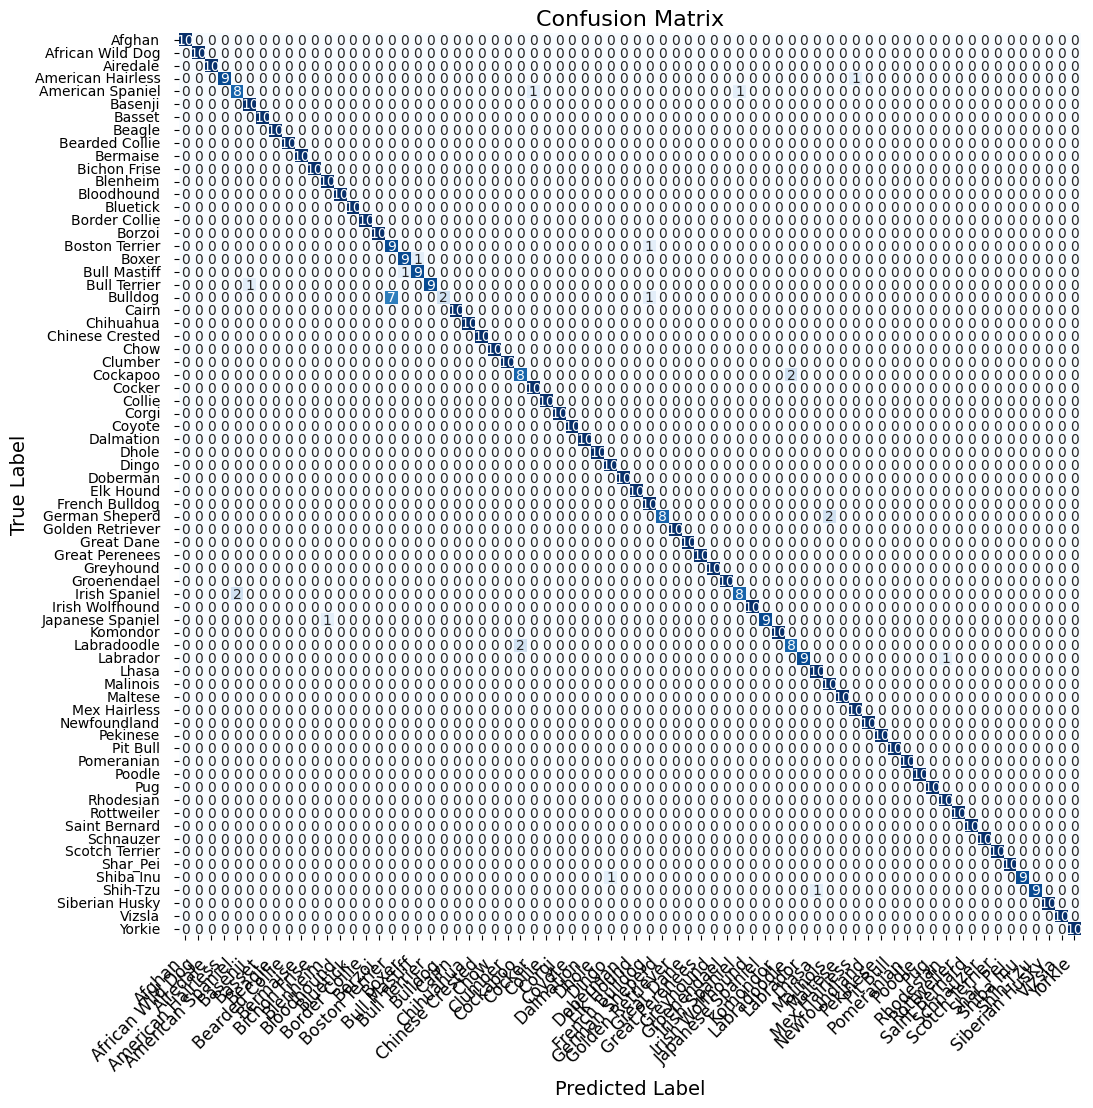

In [61]:
# Generate the confusion matrix
conf_matrix = confusion_matrix(true_classes, predicted_classes)

# Plotting the confusion matrix
plt.figure(figsize=(14, 12))  
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', cbar=False,
            xticklabels=class_labels, yticklabels=class_labels, 
            annot_kws={"size": 10}, square=True) 

plt.title('Confusion Matrix', fontsize=16)
plt.xlabel('Predicted Label', fontsize=14)
plt.ylabel('True Label', fontsize=14)

# Rotate and adjust ticks
plt.xticks(rotation=45, ha='right', fontsize=12)  

# Adjust tick padding using tick_params
plt.gca().tick_params(axis='x', pad=10)  
plt.gca().tick_params(axis='y', pad=10)  

# Add padding between heatmap cells
plt.gca().set_xticks(np.arange(len(class_labels)) + 0.5, minor=True)
plt.gca().set_yticks(np.arange(len(class_labels)) + 0.5, minor=True)
plt.gca().grid(which='minor', color='black', linestyle='-', linewidth=2)

plt.tight_layout(pad=4)  
plt.show()



1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 90ms/step


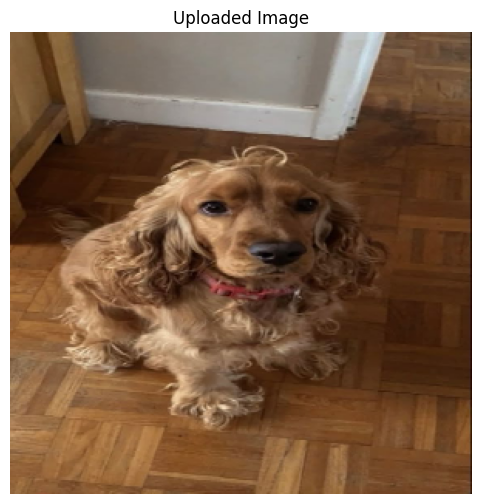

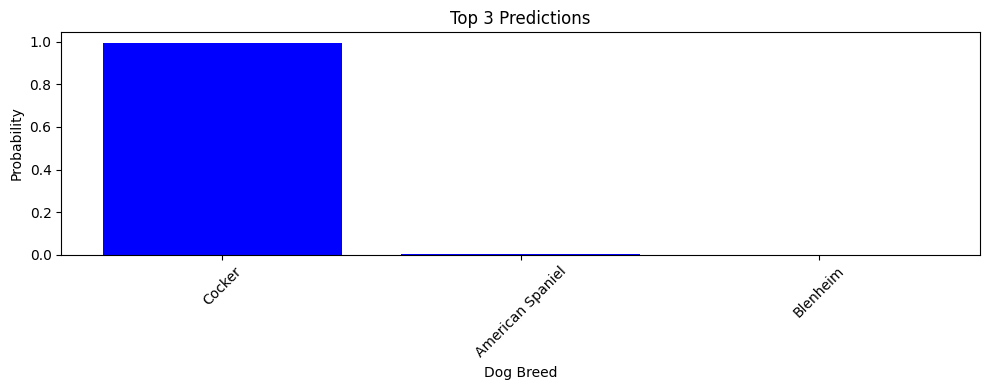

Cocker: 0.9949
American Spaniel: 0.0037
Blenheim: 0.0004


In [68]:
# Load and preprocess the example image
img_path = '/Users/sandrachee/Documents/DeepLearningProjects/dog_breed_test_images/unspecified1.jpg'  
img = image.load_img(img_path, target_size=(img_size, img_size))
img_array = image.img_to_array(img)
img_array = np.expand_dims(img_array, axis=0)
img_array /= 255.

# Predict using the model
predictions = model.predict(img_array)

# Get top 3 predictions and their probabilities
top3_indices = np.argsort(predictions[0])[::-1][:3]  
top3_probabilities = predictions[0][top3_indices]   
top3_labels = np.array(class_labels)[top3_indices]  

# Display the image
plt.figure(figsize=(6, 6))
plt.imshow(img)
plt.axis('off')
plt.title('Uploaded Image')

# Display top 3 predictions
plt.figure(figsize=(10, 4))
plt.bar(top3_labels, top3_probabilities, color='blue')
plt.xlabel('Dog Breed')
plt.ylabel('Probability')
plt.title('Top 3 Predictions')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

# Print top 3 results and their probabilities
for label, prob in zip(top3_labels, top3_probabilities):
    print(f'{label}: {prob:.4f}')